In [1]:
from config import Config
from utils import set_seeds
import random
from dataset import DataProcessor, get_loaders

args = Config()
set_seeds(args.seed)

processor = DataProcessor(args)
processor.set_data_args()

''' Get Loaders '''
loader_dict = get_loaders(args, processor.tech_dict, processor.close_dict, processor.date_dict, processor.cov_dict)

/home/dlw/anaconda3/envs/finrl/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
100%|██████████| 4007/4007 [00:29<00:00, 136.53it/s]


In [2]:
import torch
import copy
import model as model_factory
from test import eval_model, eval_model_with_costv2, eval_model_with_action_optimize
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from utils import load_torch_file

args.net_dims = '64,32'
args.action_constraint = 0.1
args.target = 'cumreturn'
args.model_name = 'LSTMHADW'

# Set Running Device
device = torch.device(args.device)
# TODO: GET DIFFERENT MODEL
model = getattr(model_factory, args.model_name)(args).to(device)

trained_model_path = ''
load_torch_file(model, trained_model_path)

/home/dlw/anaconda3/envs/finrl/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
test_loader = loader_dict['test']
test_loader, _, _, _, _ = test_loader
model.eval()
with torch.no_grad():
    all_action = []
    all_diff = []
    all_yr = []
    all_cov = []
    for batch in test_loader:
        state, diff, idx, assets_cov = [item.to(device) for item in batch]
        action, y_r = model(state, assets_cov)
        # action = action.softmax(-1)
        all_action.append(action)
        all_diff.append(diff)
        all_yr.append(y_r)
        all_cov.append(assets_cov)
all_action = torch.cat(all_action)
all_action_softmax = all_action.softmax(-1)
all_diff = torch.cat(all_diff)
all_yr = torch.cat(all_yr)
all_cov = torch.cat(all_cov)

In [4]:
# TYPE 4 Interpolation
from pypfopt.efficient_frontier import EfficientFrontier
import cvxpy
import torch
import numpy as np

total_assets = 1
total_assets_list_minvar = [total_assets]
weights_list = []
for idx in range(len(all_cov)):
    ef_min_var = EfficientFrontier(None, all_cov[idx].detach().cpu().numpy())
    try:
        raw_weights_min_var = ef_min_var.min_volatility()
        cleaned_weights_min_var = ef_min_var.clean_weights()
        weights = np.array([element for element in cleaned_weights_min_var.values()])
        total_assets = ((weights * (all_diff[idx].cpu().numpy() - 1)).sum() + 1) * total_assets
    except:
        total_assets = ((weights * (all_diff[idx].cpu().numpy() - 1)).sum() + 1) * total_assets
    total_assets_list_minvar.append(total_assets)
    weights_list.append(torch.tensor(weights, dtype=torch.float))
actions_minvar = torch.stack(weights_list)

all_diff_cpu = all_diff.detach().cpu()
all_action_softmax_cpu = all_action_softmax.detach().cpu()
total_assets_list_outer = []
n_steps = 100
values = torch.linspace(0, 1, n_steps)
for w_i in values:
    total_assets = 1
    total_assets_list_temp = [total_assets]
    adjusted_actions = (1 - w_i) * all_action_softmax_cpu + w_i * actions_minvar
    for idx in range(len(adjusted_actions)):
        total_assets = ((adjusted_actions[idx] * (all_diff_cpu[idx] - 1)).sum() + 1) * total_assets
        total_assets_list_temp.append(total_assets.item())
    total_assets_list_outer.append(total_assets_list_temp)

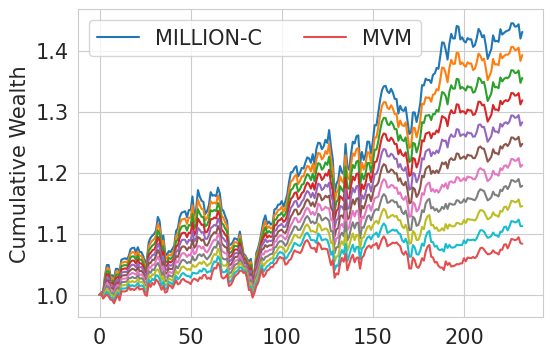

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')

total_assets = 1
total_assets_list = [total_assets]
for idx in range(len(all_action_softmax)):
    total_assets = ((all_action_softmax[idx] * (all_diff[idx] - 1)).sum() + 1) * total_assets
    total_assets_list.append(total_assets.item())

actions_minvar = actions_minvar.to(device)
total_assets = 1
total_assets_list_min = [total_assets]
for idx in range(len(all_action_softmax)):
    total_assets = ((actions_minvar[idx] * (all_diff[idx] - 1)).sum() + 1) * total_assets
    total_assets_list_min.append(total_assets.item())

n_step = 10
step_size = int(len(total_assets_list_outer) / n_step)
indexes = [i * step_size for i in range(n_step)][1:]

plt.figure(figsize=(6,4))
sns.lineplot(x=range(len(total_assets_list)), y=total_assets_list, label='MILLION-C')
for i, idx in enumerate(indexes):
    sns.lineplot(x=range(len(total_assets_list)), y=total_assets_list_outer[idx])
sns.lineplot(x=range(len(total_assets_list)), y=total_assets_list_min, label='MVM', color='#e54e4e')
plt.legend(fontsize=15, ncol=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Cumulative Wealth', fontsize=15)
plt.xlabel('')
plt.savefig('./plotted_figs/DOW30_Interpolation.pdf', bbox_inches='tight')

In [17]:
from pyfolio import timeseries

all_exp_inter = [total_assets_list] + total_assets_list_outer + [total_assets_list_min]

results_dict = {'AR': [], 'AV': [], 'SR': [], 'CR': [], 'MDD': [], 'VaR': []}

for total_assets_list_temp in all_exp_inter:
    period_return = pd.Series(np.array(total_assets_list_temp)).pct_change().dropna()
    results = timeseries.perf_stats(period_return)
    results_dict['AR'].append(results['Annual return'])
    results_dict['AV'].append(results['Annual volatility'])
    results_dict['SR'].append(results['Sharpe ratio'])
    results_dict['CR'].append(results['Calmar ratio'])
    results_dict['MDD'].append(results['Max drawdown'])
    results_dict['VaR'].append(results['Daily value at risk'])

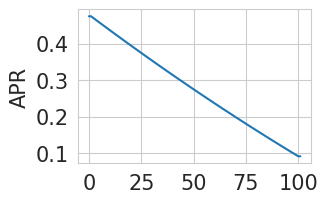

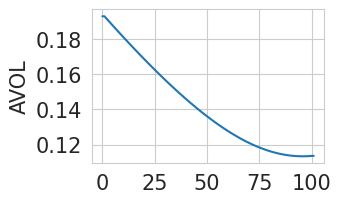

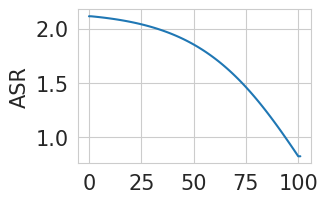

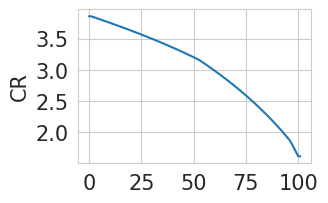

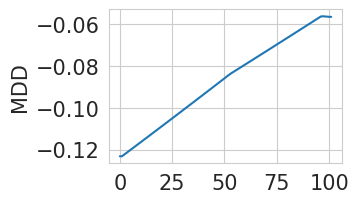

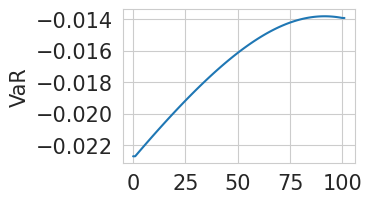

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

results_df = pd.DataFrame(results_dict)
figsize = (3,2)

sns.set_style('whitegrid')
plt.figure(figsize=figsize)
sns.lineplot(data=results_df, x=range(len(results_dict['MDD'])), y='AR')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('APR', fontsize=15)
plt.xlabel('')
# plt.show()
plt.savefig('./plotted_figs/DOW30_Interpolation_APR.pdf', bbox_inches='tight')

sns.set_style('whitegrid')
plt.figure(figsize=figsize)
sns.lineplot(data=results_df, x=range(len(results_dict['MDD'])), y='AV')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('AVOL', fontsize=15)
plt.xlabel('')
# plt.show()
plt.savefig('./plotted_figs/DOW30_Interpolation_AVOL.pdf', bbox_inches='tight')

sns.set_style('whitegrid')
plt.figure(figsize=figsize)
sns.lineplot(data=results_df, x=range(len(results_dict['MDD'])), y='SR')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('ASR', fontsize=15)
plt.xlabel('')
# plt.show()
plt.savefig('./plotted_figs/DOW30_Interpolation_ASR.pdf', bbox_inches='tight')

sns.set_style('whitegrid')
plt.figure(figsize=figsize)
sns.lineplot(data=results_df, x=range(len(results_dict['MDD'])), y='CR')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('CR', fontsize=15)
plt.xlabel('')
# plt.show()
plt.savefig('./plotted_figs/DOW30_Interpolation_CR.pdf', bbox_inches='tight')

sns.set_style('whitegrid')
plt.figure(figsize=figsize)
sns.lineplot(data=results_df, x=range(len(results_dict['MDD'])), y='MDD')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('MDD', fontsize=15)
plt.xlabel('')
# plt.show()
plt.savefig('./plotted_figs/DOW30_Interpolation_MDD.pdf', bbox_inches='tight')

sns.set_style('whitegrid')
plt.figure(figsize=figsize)
sns.lineplot(data=results_df, x=range(len(results_dict['MDD'])), y='VaR')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('VaR', fontsize=15)
plt.xlabel('')
# plt.show()
plt.savefig('./plotted_figs/DOW30_Interpolation_VaR.pdf', bbox_inches='tight')

In [112]:
actions_minvar = actions_minvar.cpu()
all_cov_cpu = all_cov.cpu()
values = torch.linspace(0, 1, n_steps)
selected_indexes = [10, 11, 12, 50, 60, 80, 110, 120, 122, 130, 140, 150, 200]
return_rates_list = []
risks_list = []
for w_i in values:
    adjusted_actions = (1 - w_i) * all_action_softmax_cpu[selected_indexes] + w_i * actions_minvar[selected_indexes]
    return_rates = (adjusted_actions * (all_diff_cpu - 1)[selected_indexes]).sum(-1)
    risks = adjusted_actions.unsqueeze(1) @ all_cov_cpu[selected_indexes] @ adjusted_actions.unsqueeze(-1)
    return_rates_list.append(return_rates)
    risks_list.append(risks.squeeze())
all_return_rates = torch.stack(return_rates_list, dim=1).cpu().numpy()
all_risks = torch.stack(risks_list, dim=1).cpu().numpy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


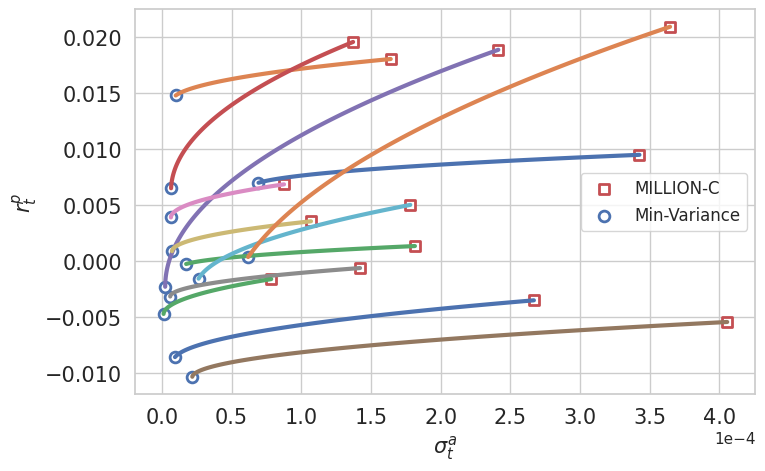

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_theme()

figsize = (8,5)

scatter_df = pd.DataFrame({"x": all_risks[:, 0].tolist() + all_risks[:, -1].tolist(), 
                           'y': all_return_rates[:, 0].tolist() + all_return_rates[:, -1].tolist(),
                           'Methods': ['MILLION'] * all_risks.shape[0] + ['Min-Vairance'] * all_risks.shape[0]})

sns.set_style('whitegrid')
plt.figure(figsize=figsize)
for i in range(len(selected_indexes)):
    sns.lineplot(x=all_risks[i], y=all_return_rates[i], linewidth=3, style=True, legend=False)
plt.legend(fontsize=12)
plt.scatter(x=all_risks[:, 0], y=all_return_rates[:, 0], label='MILLION-C', s=60, c='white', marker='s', edgecolor='r', linewidths=2)
plt.scatter(x=all_risks[:, -1], y=all_return_rates[:, -1], label='Min-Variance', s=60, c='white', marker='o', edgecolor='b', linewidths=2)
plt.legend(fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('$\mathit{r_t^p}$', fontsize=15)
plt.xlabel('$\mathit{\sigma_t^a}$', fontsize=15)
plt.ticklabel_format(axis='x', style='sci', scilimits=[0, 2])
# plt.show()
plt.savefig('./plotted_figs/DOW30_Interpolation_Risk_Return.pdf', bbox_inches='tight')